In [1]:
#!pip install ujson

In [1]:
import ujson as json
import pandas as pd
import numpy as np
from collections import Counter
import pickle as pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import re
import unicodedata

import tensorflow
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

In [2]:
# loading data from local folder
df = pd.read_json('wp_movies_10k.ndjson', lines=True)
df.columns=['movie', 'info', 'links', 'rating1', 'rating2']

In [3]:
df

,movie,info,links,rating1,rating2
0,Deadpool (film),"{'image': 'Deadpool poster.jpg', 'name': 'Dead...","[Tim Miller (director), Simon Kinberg, Ryan Re...",84%,6.9/10
1,The Revenant (2015 film),"{'image': 'The Revenant 2015 film poster.jpg',...","[Alejandro González Iñárritu, Arnon Milchan, S...",82%,7.9/10
2,Suicide Squad (film),"{'image': 'Suicide Squad (film) Poster.png', '...","[David Ayer, Charles Roven, Richard Suckle, Wi...",26%,4.7/10
3,Spectre (2015 film),"{'image': 'spectre poster.jpg', 'name': 'Spect...","[Sam Mendes, Michael G. Wilson, Barbara Brocco...",65%,
4,Rebel Without a Cause,"{'distributor': 'Warner Bros.', 'image': 'Rebe...","[Nicholas Ray, David Weisbart, Stewart Stern, ...",96%,
...,...,...,...,...,...
9995,Prelude to a Kiss (film),"{'image': 'PreludeKissPoster.jpg', 'name': 'Pr...","[Norman René, Michael Gruskoff, Craig Lucas, A...",61%,
9996,The Black Balloon (film),{'image': 'TheBlackBalloon_Official-Poster.jpg...,"[Elissa Down, Jimmy Jack, Rhys Wakefield, Luke...",88%,
9997,Freelancers (film),"{'image': 'Freelancers (film).jpg', 'name': 'F...","[Jessy Terrero, Mark Canton, 50 Cent, Cheetah ...",None,None
9998,Difret,"{'image': 'Difret poster.jpg', 'name': 'Difret...","[Dave Eggar, 2014 Sundance Film Festival, The ...",None,None


# Фильмы и ссылки

In [4]:
# Example of links for a movie
print(len(df['links'][1]))
df['links'][1]

342


['Alejandro González Iñárritu',
 'Arnon Milchan',
 'Steve Golin',
 'Mary Parent',
 'Keith Redmon',
 'James W. Skotchdopole',
 'Mark L. Smith',
 'The Revenant (novel)',
 'Michael Punke',
 'Leonardo DiCaprio',
 'Tom Hardy',
 'Domhnall Gleeson',
 'Will Poulter',
 'Ryuichi Sakamoto',
 'Alva Noto',
 'Emmanuel Lubezki',
 'Stephen Mirrione',
 '20th Century Fox',
 'TCL Chinese Theatre',
 'British Board of Film Classification',
 'TheWrap',
 'Box Office Mojo',
 'Regency Enterprises',
 'RatPac-Dune Entertainment',
 'Anonymous Content',
 'Appian Way Productions',
 'Biographical film',
 'Business Insider',
 'Western (genre)',
 'Alejandro González Iñárritu',
 'Mark L. Smith',
 'Michael Punke',
 'The Revenant (novel)',
 'frontiersman',
 'Hugh Glass',
 'Leonardo DiCaprio',
 'Tom Hardy',
 'Domhnall Gleeson',
 'Will Poulter',
 'Akiva Goldsman',
 'Principal photography',
 'TCL Chinese Theatre',
 'limited release',
 'wide release',
 'cinematography',
 'Golden Globe Awards',
 'BAFTA Awards',
 '88th Academy

In [5]:
# Counting the total number of links
all_links = []

for i in range(len(df)):
    for link in df['links'][i]:
        all_links.append(link)
print('Total number of links in dataframe: ', len(all_links))

Total number of links in dataframe:  1135559


In [7]:
# Counting the number Подсчитаем число вхождений каждой ссылки
link_counter = Counter(all_links)
common_links = link_counter.most_common()

print('Number of unique links: ', len(common_links))
print('Most common links:')
common_links[0:20]

Number of unique links:  218029
Most common links:


[('Rotten Tomatoes', 9393),
 ('Category:English-language films', 5882),
 ('Category:American films', 5867),
 ('Variety (magazine)', 5450),
 ('Metacritic', 5112),
 ('Box Office Mojo', 4186),
 ('The New York Times', 3818),
 ('The Hollywood Reporter', 3553),
 ('Roger Ebert', 2707),
 ('Los Angeles Times', 2454),
 ('Entertainment Weekly', 2375),
 ('British Board of Film Classification', 2236),
 ('Chicago Sun-Times', 1826),
 ('Deadline.com', 1814),
 ('The Guardian', 1528),
 ('American Film Institute', 1516),
 ('DVD', 1502),
 ('Category:Indian films', 1452),
 ('Warner Bros.', 1424),
 ('New York City', 1293)]

In [8]:
# Посмторитрим, сколько ссылок встречается один раз
n = 0
for i in common_links:
    if i[1] == 1:
        n += 1
        
print('Number of links appearing only once: ', n)

Number of links appearing only once:  116217


In [9]:
# Возьмем только ссылки, которые встречаются больше одного раза
remaining_links = [link for link, count in link_counter.items() if count > 1]
print('Number of remaing links: ', len(remaining_links))

Number of remaing links:  101812


In [10]:
# Составим индексы для уникальных ссылок
link2index = {link: i for i, link in enumerate(remaining_links)}
index2link = {i: link for link, i in link2index.items()}

print('First links:') 
list(link2index)[0:10]

First links:


['Tim Miller (director)',
 'Simon Kinberg',
 'Ryan Reynolds',
 'Lauren Shuler Donner',
 'Rhett Reese',
 'Paul Wernick',
 'Deadpool',
 'Rob Liefeld',
 'Morena Baccarin',
 'Ed Skrein']

In [11]:
# Составим индексы для фильмов
movie2index = {movie: i for i, movie in enumerate(df['movie'])}
index2movie = {i: movie for movie, i in movie2index.items()}

print('Number of movies: ', len(movie2index))
print('First movies:')
list(movie2index)[0:10]

Number of movies:  10000
First movies:


['Deadpool (film)',
 'The Revenant (2015 film)',
 'Suicide Squad (film)',
 'Spectre (2015 film)',
 'Rebel Without a Cause',
 'Warcraft (film)',
 'The Martian (film)',
 'List of Marvel Cinematic Universe films',
 'X-Men (film series)',
 'The Hateful Eight']

In [12]:
# Сохраним словарь для фильмов
save_file = open('movies2index.pkl', 'wb')
pickle.dump(movie2index, save_file)
save_file.close()

In [13]:
# Составим словарь фильм-страна
movie2country = {}
for i, movie in enumerate(df['movie']):
    country = df['info'][i].get('country')
    
    if country != None:
        country = re.sub(r'http\S+', '', country)
        
    movie2country[movie] = country

Рейтинг

In [14]:
# Составим словарь фильм-рейтинг
# Рейтинг берётся как среднее значение по двум имеющимся рейтингам

movie2raiting = {}
for i in range(len(df)):
    r = None
    
    movie = df['movie'][i]
    r1 = df['rating1'][i]
    r2 = df['rating2'][i]

    if r1 not in ['',  None]:
        if r2 not in ['',  None]:
            r1 = float(re.sub(r'%', '', r1))/10
            r2 = float(re.sub(r'\/\d', '', r2))
            r = round((r1+r2)/2, 1)
        else: 
            r1 = float(re.sub(r'%', '', r1))/10
            r = round(r1, 1)
    elif r2 not in ['',  None]:
        r2 = float(re.sub(r'\/\d', '', r2))
        r = round(r2, 1)
        
    movie2raiting[movie] = r

In [15]:
# Пример среднего рейтинга для первых 10 фильмов
list(movie2raiting.values())[0:10]

[7.7, 8.1, 3.7, 6.5, 9.6, 3.5, None, None, None, 7.4]

In [16]:
# Сохраним словарь для рейтинга
save_file = open('movie2raiting.pkl', 'wb')
pickle.dump(movie2raiting, save_file)
save_file.close()

# Составление пар фильм-ссылка

In [17]:
# Составим пары фильм-ссылка
pairs = []
for i, movie in enumerate(df['movie']):
    links = df['links'][i]
    for link in links:
        if link in link2index.keys():
            pairs.append((movie2index[movie], link2index[link]))
            
print('Number of pairs: ', len(pairs))

Number of pairs:  1019342


In [18]:
# Пример одной из пар
p = pairs[3]
print('Pair: ', p)
print('Movie: %s, Link: %s' % (index2movie[p[0]], index2link[p[1]]))

Pair:  (0, 3)
Movie: Deadpool (film), Link: Lauren Shuler Donner


In [19]:
# Множество неповторяющихся пар
set_pairs = set(pairs)
print('Number of set pairs: ', len(set_pairs))

Number of set pairs:  727866


# Модель для обучения эмбеддингов

In [20]:
def build_model(embedding_size = 50):
    '''Построение модели для создания эмбеддингов'''

    # Оба входа имеют размерность 1
    movie = Input(name = 'movie', shape = [1])
    link = Input(name = 'link', shape = [1])

    # Эмбеддинги для фильмов (None, 1, 50)
    movie_embedding = Embedding(name = 'movie_embedding',
                               input_dim = len(movie2index),
                               output_dim = embedding_size)(movie)

    # Эмбеддинги для ссылок (None, 1, 50)
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link2index),
                               output_dim = embedding_size)(link)
    
    # Слияние слоёв с помощью Dot вдоль второй оси
    # (None, 1, 1)
    merged = Dot(name = 'dot_product', normalize = True, 
                 axes = 2)([movie_embedding, link_embedding])
    
    # Reshape к единичному числу (None, 1)
    merged = Reshape(target_shape = [1])(merged)
    
    # Выходы для классификации
    out = Dense(1, activation = 'sigmoid')(merged)
    model = Model(inputs = [movie, link], outputs = out)
    
    # Компилляция
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
link (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        500000      movie[0][0]                      
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 50)        5090600     link[0][0]                       
_______________________________________________________________________________________

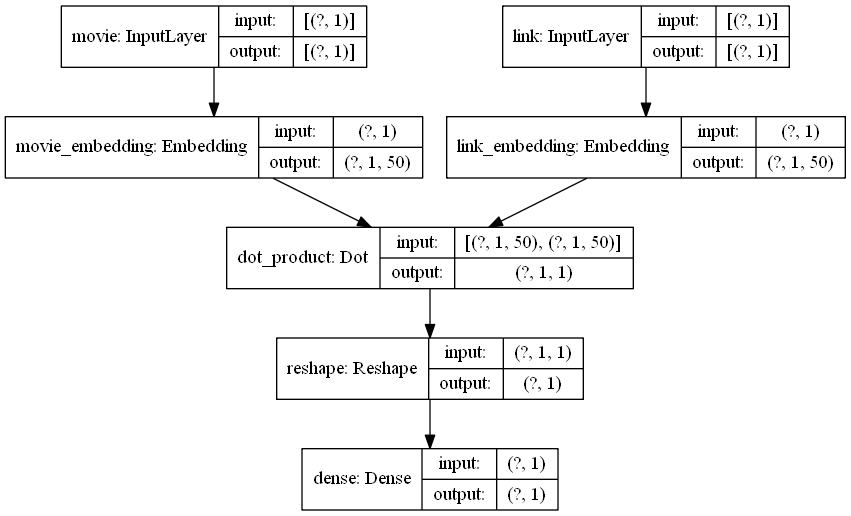

In [21]:
# Построим и визуализируем модель
dim_embedding = 50   # размерность эмбеддингов
model = build_model(embedding_size = dim_embedding)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Составление обучающих батчей

In [22]:
random.seed(2021)

def batch_generator(pairs, n_positive = 50, negative_ratio = 1.0):
    '''Генерирует батчи для тринировки модели.
    Случайным образом выбирает положительные пары и отрицательные'''
    
    # Создаем пустой массив для батчей
    batch_size = int(n_positive * (1 + negative_ratio))
    batch = np.zeros((batch_size, 3))
    
    # Выполняется до тех пор, пока не выдаст yield
    while True:
        # Случайно выбираем положителные пары
        for idx, (movie_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (movie_id, link_id, 1)
        idx += 1
        
        # Добавляем отрицательные пары до заполнения батча
        while idx < batch_size:
            
            # Случайно выбираем фильм и ссылку
            random_movie = random.randrange(len(movie2index))
            random_link = random.randrange(len(link2index))
            
            # Проверяем, что это не положительная пара
            if (random_movie, random_link) not in set_pairs:
                
                # Добавляем в батч и увиличеваем индекс
                batch[idx, :] = (random_movie, random_link, -1)
                idx += 1
                
        # Перемешаем положительные и отрицательные пары
        np.random.shuffle(batch)
        yield {'movie': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

In [23]:
# Пример батча
next(batch_generator(pairs, n_positive=3))

({'movie': array([8914., 8189., 4052.,  567., 7856., 2639.]),
  'link': array([36269.,   353., 83233., 58127.,   181.,  5433.])},
 array([-1.,  1., -1., -1.,  1.,  1.]))

In [24]:
def check_pair(N_movie, N_link):
    '''Проверка, к положительному или отрицательному классу относится ссылка'''
    m = index2movie[N_movie]
    l = index2link[N_link]
    print('Movie: ', m)
    print('Link: ', l)

    if l in list(df[df['movie'] == m]['links'])[0]:
        print('Link IS in the links for the movie')
    else:
        print('Link IS NOT in the links for the movie')

In [25]:
# Положительная пара из батча
check_pair(7856, 181)

Movie:  The Hills Have Eyes Part II
Link:  Rotten Tomatoes
Link IS in the links for the movie


In [26]:
# Отрицательная пара из батча
check_pair(8914, 36269)

Movie:  Paulie
Link:  Leonardo Cimino
Link IS NOT in the links for the movie


In [27]:
# Посмотрим на время формирования батча
%time next(batch_generator(pairs, 1024, negative_ratio = 2))

Wall time: 11 ms


({'movie': array([5207.,  323., 4766., ..., 1607., 3585., 1203.]),
  'link': array([22609., 23962., 42295., ..., 35520., 82985., 49255.])},
 array([-1.,  1.,  1., ..., -1., -1.,  1.]))

# Обучение модели

In [28]:
# Если имеется уже сохранённая модель, можно её загрузить в следуюющей ячейке и эту ячейку не выполнять
n_positive = 1024
start = time()

model.fit(batch_generator(pairs, n_positive, negative_ratio = 2),
          epochs=15,
          steps_per_epoch=len(pairs) // n_positive)

print('Training time (s): ', round((time()-start), 1))

# Сохраним обученную модель
model.save('model_movies50.h5')

Epoch 1/15
995/995 [==============================] - 41s 42ms/step - loss: 0.1518 - accuracy: 0.0335
Epoch 2/15
995/995 [==============================] - 41s 41ms/step - loss: -1.6387 - accuracy: 0.1233
Epoch 3/15
995/995 [==============================] - 41s 41ms/step - loss: -2.6628 - accuracy: 0.1228
Epoch 4/15
995/995 [==============================] - 41s 41ms/step - loss: -3.5894 - accuracy: 0.1214
Epoch 5/15
995/995 [==============================] - 42s 42ms/step - loss: -4.5189 - accuracy: 0.1209
Epoch 6/15
995/995 [==============================] - 46s 46ms/step - loss: -5.4497 - accuracy: 0.1206
Epoch 7/15
995/995 [==============================] - 43s 44ms/step - loss: -6.3880 - accuracy: 0.1207
Epoch 8/15
995/995 [==============================] - 54s 55ms/step - loss: -7.3173 - accuracy: 0.1201 0s - loss: -7.3107 - accu
Epoch 9/15
995/995 [==============================] - 53s 53ms/step - loss: -8.2520 - accuracy: 0.1199
Epoch 10/15
995/995 [===========================

In [37]:
# Загрузка сохранённой модели
model = load_model('model_movies50.h5')

# Эмбеддинги для фильмов

In [38]:
# Извлекаем эмбеддинги для фильмов
movie_layer = model.get_layer('movie_embedding')
movie_weights = movie_layer.get_weights()[0]

# Считаем модули векторов
lengths = np.linalg.norm(movie_weights, axis=1)
# Нормализуем вектора
movies_norm = (movie_weights.T / lengths).T

print('Shape of movies_norm: ', movies_norm.shape)

Shape of movies_norm:  (10000, 50)


In [39]:
# Пример вектора для первого фильма
movies_norm[0]

array([ 0.04594709, -0.0225429 ,  0.0238872 ,  0.00838841, -0.2196424 ,
        0.2043815 ,  0.1486607 , -0.1705743 , -0.25526875,  0.16005743,
        0.01885609, -0.21560654, -0.01586457, -0.09874642, -0.14043103,
       -0.13700502,  0.22659957,  0.17615202,  0.12615572, -0.04632395,
       -0.1873926 ,  0.18791763, -0.11104966,  0.03568028,  0.11387146,
        0.14005093, -0.09493593,  0.21237165, -0.06650787,  0.22564173,
       -0.08808407,  0.00958635, -0.05362476,  0.18619464,  0.10974474,
       -0.11145384,  0.05226882, -0.09847753,  0.07650486, -0.19719605,
        0.1728388 , -0.14990681,  0.1346081 , -0.14097503, -0.17954926,
       -0.18488915, -0.23978426, -0.02259457, -0.00958685,  0.03192348],
      dtype=float32)

In [40]:
# Сохраним эмбеддинги для фильмов
save_file = open('movies_emb50.pkl', 'wb')
pickle.dump(movies_norm, save_file)
save_file.close()

In [41]:
def similar_movies(movie):
    '''
    Подсчитывается косинус-расстояние между нормированными эмбеддингами для заданного фильма и остальных фильмов.
    Выбираются 10 наиболее близких фильмов
    '''
    # Подсчитываем расстояния
    distances = np.dot(movies_norm, movies_norm[movie2index[movie]])

    # Берём индексы для десяти ближайших фильмов
    similar = np.argsort(distances)[-10:]

    # Выводим индекс фильма, название и расстояние до заданного фильма
    for k in reversed(similar):
        print(k, df['movie'][k], distances[k])

In [42]:
# Пример поиска похожих фильмов
similar_movies('Youth (2015 film)')

288 Youth (2015 film) 1.0000001
9206 Certified Copy (film) 0.9988323
6100 In a Better World 0.99857366
4322 A Very Long Engagement 0.9983498
6594 The Broken Circle Breakdown 0.99831665
1362 Mustang (film) 0.998309
5783 Brideshead Revisited (film) 0.9981936
1588 A Royal Affair 0.9981096
6991 Chronic (film) 0.9980748
6743 Europa Europa 0.9980438


In [43]:
# Развлекательные фильмы
similar_movies('Deadpool (film)')

0 Deadpool (film) 1.0
182 The Amazing Spider-Man 2 0.99613637
20 Ant-Man (film) 0.9931088
39 Guardians of the Galaxy (film) 0.9923756
42 The Avengers (2012 film) 0.9908686
67 DC Extended Universe 0.9900319
1364 Captain America: Civil War 0.9898749
34 Doctor Strange (film) 0.9891132
372 The Amazing Spider-Man (2012 film) 0.9884423
22 Jurassic World 0.98837024


In [44]:
# Получаем близкие индийские фильмы, задав индийский фильм
similar_movies('Mayabazar')

7534 Mayabazar 1.0
2227 Rang De Basanti 0.986467
483 Ennu Ninte Moideen 0.9836886
9790 Gemini (2002 Tamil film) 0.97724694
3013 Anniyan 0.97617364
1691 Manam (film) 0.97557837
2679 Govindudu Andarivadele 0.97436744
3373 Vaaranam Aayiram 0.97266895
2047 Magadheera 0.97149247
2666 Mankatha 0.97045255


In [50]:
def get_X(movies_list):
    'Возвращает вектора для списка фильмов'
    X = np.zeros((len(movies_list), dim_embedding))

    for i, movie in enumerate(movies_list):
        X[i] = movies_norm[movie2index[movie]]

    return X   

def plot_tsne(movies_list, labels=False):
    '''Для заданного списка фильмов показывает на графике расположение их векторов
    с помощью преобразования TSNE'''
    
    X = get_X(movies_list)
    tsne = TSNE(n_components=2, random_state=2021)
    X_reduced = tsne.fit_transform(X)

    plt.figure(figsize=(16,10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='blue')
    
    # Добавляет названия фильмов к изображённым точкам
    if labels:
        for label, x, y in zip(movies_list, X_reduced[:, 0], X_reduced[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
            
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.title('Arrangement of embeddings using TSNE')
    plt.savefig("Embeddings_TSNE.jpg", dpi=150)
    plt.show()

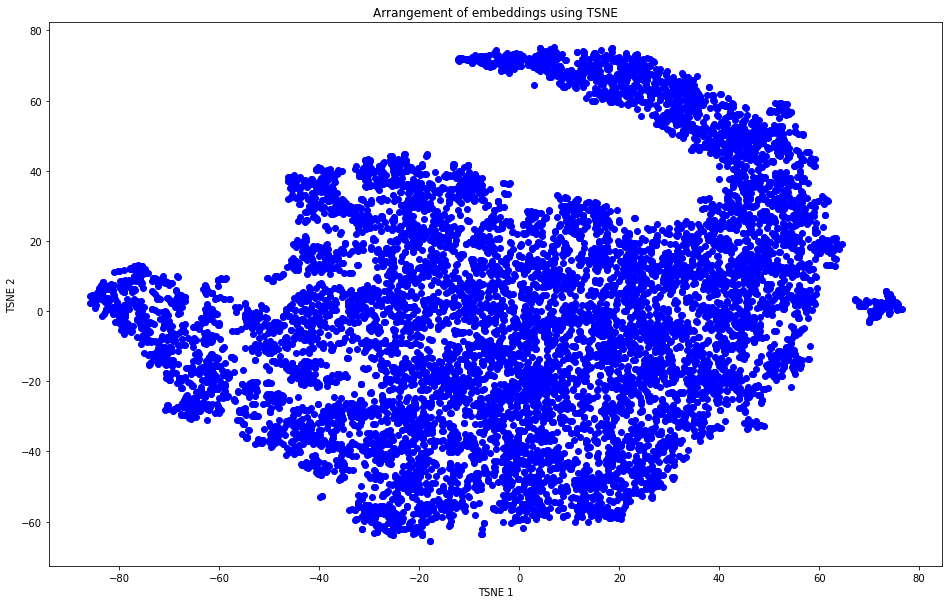

In [51]:
# Изобразим эмбеддинги всех фильмов с помощью преобразования TSNE
plot_tsne(list(df['movie']))

In [52]:
# Отберём фильмы из нескольких стран
# Это разделение условное, так как фильм может быть создан при участии нескольких стран
movie2country_selected = {}

country_selected = ['United States', 'India', 'South Korea', 'China', 'France', 'Soviet Union',  'Russia']
#country_selected = ['United States', 'India', 'Russia']
    
for movie in df['movie']:
    country = movie2country[movie]
        
    if country != None:
        for count in country_selected:
            if count in country:
                movie2country_selected[movie] = count

In [54]:
def plot_tsne_countries(movies_countries):
    '''Для заданного списка фильмов показывает на графике расположение их векторов
    с помощью преобразования TSNE.
    Выделяет цветом фильмы, относящиеся к разным странам'''
    
    X = get_X(list(movies_countries))
    tsne = TSNE(n_components=2, random_state=2021)
    X_reduced = tsne.fit_transform(X)
    
    df_country = pd.DataFrame({'movie': movie2country_selected.keys(),
                           'country': movie2country_selected.values(),
                           'tsne1': X_reduced[:, 0], 'tsne2': X_reduced[:, 1]})
    #print(df_country)
    plt.figure(figsize=(16,10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], color='blue')
    
    sns.scatterplot(data=df_country, x='tsne1', y='tsne2', hue='country', edgecolor='none')
            
    plt.xlabel('TSNE 1')
    plt.ylabel('TSNE 2')
    plt.title('Arrangement of embeddings using TSNE')
    plt.savefig("Embeddings_countries_TSNE.jpg", dpi=150)
    plt.show()

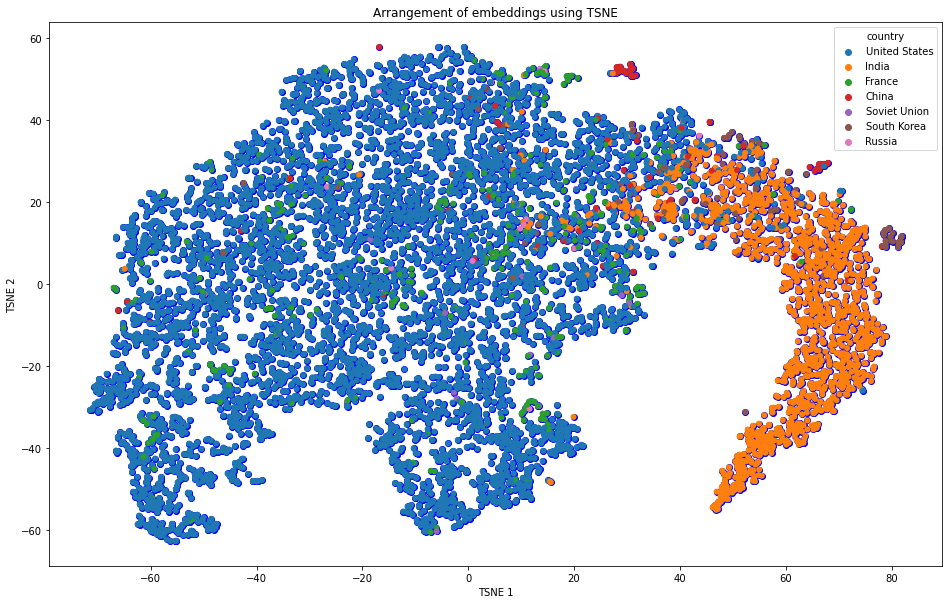

In [55]:
# Посмотрим эмбеддинги для фильмов из разных стран
plot_tsne_countries(movie2country_selected)

# Группа индийских фильмов отделена от основной массы фильмов
# Для китайских фильмов видны две небольшие отдельные группы
# У южно-корейский фильмов тоже видна отдельная группа

# Рекомендации на основе нескольких фильмов

In [59]:
# Составим список любимых фильмов
favorite_movies = ['The Great Beauty', 'The Lobster', 'Spring, Summer, Fall, Winter... and Spring',
                   '3-Iron', 'Stalker (1979 film)', 'Requiem for a Dream', 'Dogville']
# Список нелюбимых фильмов
unliked_movies = ['Avatar (2009 film)', 'Warcraft (film)', '300 (film)',
                   'The Texas Chain Saw Massacre', 'The Conjuring', 'The Conjuring 2']

In [60]:
def prepare_classes(positive_movies, negative_movies):
    '''Создаёт два набора данных: любимые и нелюбимые фильмы'''
    
    selected_movies = positive_movies + negative_movies
    X = np.zeros((len(selected_movies), dim_embedding))
    Y = np.zeros(len(selected_movies))

    for i, movie in enumerate(selected_movies):
        X[i] = movies_norm[movie2index[movie]]
        if movie in positive_movies:
            Y[i] = 1
        else:
            Y[i] = -1

    return X, Y

In [61]:
X, Y = prepare_classes(favorite_movies, unliked_movies)
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)
print('Examples in positive class: ', len(Y[Y==1]))
print('Examples in negative class: ', len(Y[Y==-1]))

X shape:  (13, 50)
Y shape:  (13,)
Examples in positive class:  7
Examples in negative class:  6


In [62]:
# Возьмём классификатор KNN
# Зададим количество ближайший соседей больше, чем число примеров в положительном классе
clf = KNeighborsClassifier(n_neighbors=len(favorite_movies)+1,
                           weights='distance', metric='minkowski', p=2)
clf.fit(X, Y)

KNeighborsClassifier(n_neighbors=8, weights='distance')

In [63]:
# Считаем вероятность отнесения ко второму классу (положительному)
movie_rating = clf.predict_proba(movies_norm)[0:,1]
# Сортируем индексы фильмов по увеличению вероятности отнесения к положительному классу
sorted_movies = np.argsort(movie_rating)[-20:]
#sorted_movies = np.argsort(movie_rating)[:20]

# 20 наиболее рекомендуемых фильмов (включая уже заданные)
print('index - movie\'s name - probability:')
for k in reversed(sorted_movies):
    print(k, df['movie'][k], movie_rating[k])

index - movie's name - probability:
1753 The Great Beauty 1.0
357 Requiem for a Dream 1.0
1548 Stalker (1979 film) 0.9999999441523983
9187 3-Iron 0.9999998111110134
5182 Spring, Summer, Fall, Winter... and Spring 0.9999997713986467
2070 Dogville 0.9999996931686941
120 The Lobster 0.9999995580120483
3408 The Mirror (1975 film) 0.938385150333464
3121 Kes (film) 0.937890079429074
8680 Water Lilies (film) 0.9378746026325916
7380 Pandora's Box (1929 film) 0.9376889246115989
7456 Dersu Uzala (1975 film) 0.9376294163914551
7525 Manon des Sources (1986 film) 0.9375212666869417
4869 Uppu Karuvaadu 0.937150267984863
4665 Viceroy's House (film) 0.9367949052841091
9171 L'Eclisse 0.9365759122870384
2094 Bicycle Thieves 0.9364653128034539
5434 Backtrack (2015 film) 0.9362184949831119
6528 Through a Glass Darkly (film) 0.9361595391678684
3119 Swimming Pool (film) 0.9361492857768182


In [64]:
def recommendation(positive_movies, negative_movies=[]):
    recommended_movies = []
    mean_rating = []
    
    '''Если только один фильм в одном из классов, либо нет отрицательных фильмов,
    то рекоммендация производится по близости эмбеддингов к эмбеддингам положительного класса.
    Если по крайней мере есть два фильма в каждом из классов, то строится KNN классификатор
    для рекоммендации фильмов.
    Для рекомендуемых фильмов также выводится их средний рейтинг.'''
    
    # Один пример в положительном классе
    if len(positive_movies) == 1:
        movie = positive_movies[0]
        distances = np.dot(movies_norm, movies_norm[movie2index[movie]])
        similar = np.argsort(distances)[-11:]
        
        for k in reversed(similar):
            mov = index2movie[k]
            recommended_movies.append(mov)
            mean_rating.append(movie2raiting[mov])
        return recommended_movies[1:], mean_rating
    
    # Несколько примеров в положительном классе
    if len(positive_movies) >= 2:
        
        # Один пример в отрицательном классе и несколько в положительном
        if len(negative_movies) < 2:
            X = np.zeros((len(positive_movies), dim_embedding))
            for i, movie in enumerate(positive_movies):
                X[i] = movies_norm[movie2index[movie]]
            # Среднее значение для вектора эбмеддингов
            X = np.mean(X, axis=0)
            
            distances = np.dot(movies_norm, X)
            similar = np.argsort(distances)[-(10+len(positive_movies)):]
            
            for k in reversed(similar):
                mov = index2movie[k]
                if mov not in positive_movies:
                    recommended_movies.append(mov)
                    mean_rating.append(movie2raiting[mov])
            #return recommended_movies[len(positive_movies):]
            return recommended_movies, mean_rating
        
        # Несколько примеров в каждом из классов
        if len(negative_movies) >= 2:
            X, Y = prepare_classes(positive_movies, negative_movies)
            
            # Обучаем KNN классификатор
            clf = KNeighborsClassifier(n_neighbors=len(positive_movies)+1,
                           weights='distance', metric='minkowski', p=2)
            clf.fit(X, Y)
            
            # Считаем вероятность отнесения ко второму классу (положительному)
            movie_rating = clf.predict_proba(movies_norm)[0:,1]
            # Сортируем индексы фильмов по увеличению вероятности отнесения к положительному классу
            sorted_movies = np.argsort(movie_rating)[-(10+len(positive_movies)):]

            # 10 наиболее рекомендуемых фильмов
            for k in reversed(sorted_movies):
                mov = index2movie[k]
                if mov not in positive_movies:
                    recommended_movies.append(mov)
                    mean_rating.append(movie2raiting[mov])
            return recommended_movies, mean_rating
                

In [65]:
# Пример рекоммендации на основе двух любимых фильмов
recommendation(favorite_movies[0:2])

(['Two Days, One Night',
  'The Diving Bell and the Butterfly (film)',
  'We Need to Talk About Kevin (film)',
  'The Tribe (2014 film)',
  'Clouds of Sils Maria',
  'Blue Is the Warmest Colour',
  'The Hunt (2012 film)',
  'Love & Friendship',
  'Antichrist (film)',
  'Bright Star (film)'],
 [9.7, 9.3, 7.6, 8.1, 8.9, 8.6, 9.4, 9.8, 4.9, 8.2])

In [66]:
# Пример рекоммендации на основе любимых и нелюбимых фильмов
recommendation(favorite_movies, unliked_movies)

(['The Mirror (1975 film)',
  'Kes (film)',
  'Water Lilies (film)',
  "Pandora's Box (1929 film)",
  'Dersu Uzala (1975 film)',
  'Manon des Sources (1986 film)',
  'Uppu Karuvaadu',
  "Viceroy's House (film)",
  "L'Eclisse",
  'Bicycle Thieves'],
 [None, 10.0, None, 9.0, None, None, None, None, None, 9.8])